<a href="https://colab.research.google.com/github/Dr-Carlos-Villasenor/RNA_Libro/blob/main/P07_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neuronales Artificiales
# Capítulo 7
## Ejercicio práctico 7.15
### Transferencia de aprendizaje

Elaborado por: Nancy Arana-Daniel, Carlos Lopez-Franco, Javier Gomez-Avila, Carlos Villaseñor


(Información del Copyright)

## Introducción

Las arquitecturas profundas de redes nueronales artificiales necesecitan una gran cantidad de datos y hardware específicos para lograr tiempos asequibles. Con lo anterior, podría llegarse a pensar que entrenar redes neuronales profundas solo les es posible a las grandes industrias y centros de investigación; y aunque por un breve tiempo así fue, hoy día conocemos técnicas que nos permiten reutilizar arquitecturas previamente entrenadas.

La transferencia de aprendizaje es un metodología que nos permite reusar arquitecturas entrenadas en grandes bases de datos y reutilizarlas para nuestros propios problemas.

En este ejercicio práctico encontraras una guia de implementación de transferencia de aprendizaje.


## Importación de paquetes

1.  Importe la siguiente paqueterías. Note que aparte de las paqueterías básicas de importamos del modulo keras.applications en este modulo se guardan muchos modelos preentrenados en diferentes base de datos, por ejemplo:



*   ResNet50V2
*   InceptionV3
*   MobileNetV2
*   DenseNet121
*   EfficientNet
*   ConvNeXt

Para una mejor referencia visite el [sitio](https://keras.io/api/applications/).

Para está practica utilizaremos MobileNetV2. Un modelo de apredizaje profundo convolucional que es compacto.



In [3]:
# Paquetería base de ciencias de datos.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Paqueteria generales de Keras/Tesorflow
import keras
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D

# Paquetería para transferencia de aprendizaje
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

# Paquetería para aumetación de datos
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

## Carga del conjunto de datos.

2. Cargamos un conjunto de datos de prueba y lo descomprimimos. En su carpeta raíz tendrá una carpeta llamada "train", con subcarpetas por cada clase.

In [ ]:
# Carga desde el repositorio
!wget "https://github.com/Dr-Carlos-Villasenor/RNA_Libro/raw/main/DataSet/train.zip"


# Descompresión del conjunto de datos.
!unzip train.zip

## Transferencia de aprendizaje
3. Descarga el modelo de MobileNetV2 Pre-entrenado con el conjunto de datos de [ImageNet](https://www.image-net.org/)

In [ ]:
# Instanciamos el modelo con los pesos entrenados sobre el dataset de ImageNet
# No incluimos el top (las capas densas al final de la red ya que son las más
# especializadas en el problema).
base_model = MobileNetV2(weights='imagenet', include_top=False)

# Imprimimos el resumen de la arquitectura.
print(base_model.summary())

4. Ahora que ya no tenemos las capas densas, necesitamos instanciar nuevas capas y conectarlas a nuestra red actual, se ha visto de manera empírica que incluir una capa de Global Average Pooling, mejora los resultados, despues agregamos las capas densas que sean necesarias (según la complejidad del problemas) y en la última capa dejamos 3 clases ya que haremos una clasificación de tres animales distintos.

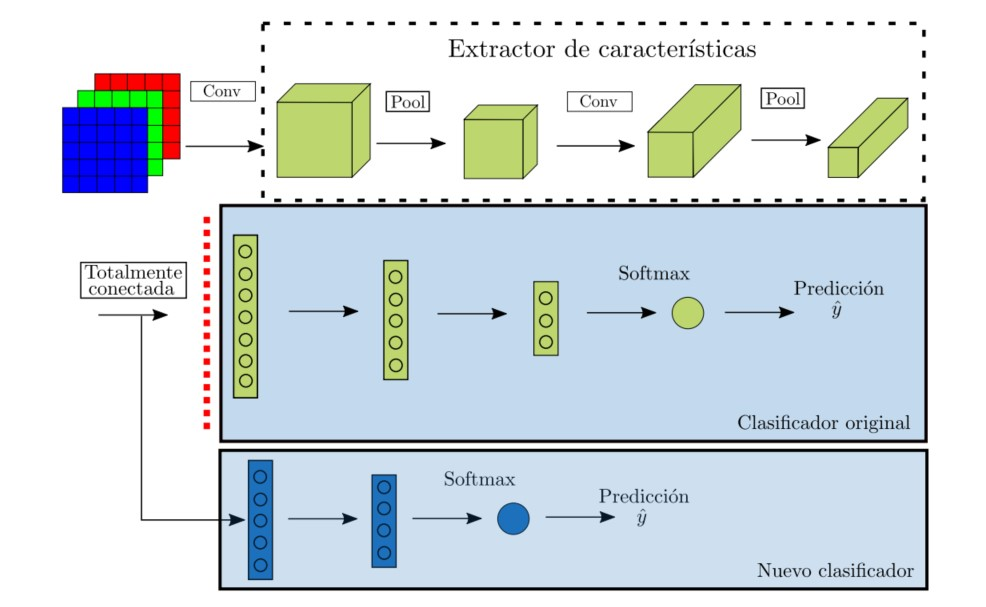

In [5]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(128,activation='relu')(x)
x=Dense(32,activation='relu')(x)
preds=Dense(3, activation='softmax')(x)

5. Con el comando model terminamos de consolidar nuestro nuevo modelo neuronal. Imprimimos el resumen del modelo solo para apreciar las nuevas capas.

In [ ]:
model=Model(inputs=base_model.input, outputs=preds)
print(model.summary())

6. Aunque estamos usando un modelo preentrenado hacer el entrenamiento de una red neuronal profunda puede llevarnos desde horas a días y solo suele dar buenos resultados cuando se tienen los suficientes datos.  En general no entrenamos todas las capas neuronales, solo es forzoso entrenar las capas nuevas que fueron agregadas. En cuanto a las otras capas dependera de la cantidad de datos y la expetiencia del usuario. A continuación define la variable capas_a_entrenar según la cantidad de datos que se tienen.

In [11]:
# Define el número de capas a entrenar de la red neuronal, siempre tiene que ser
# mayor al número de capas virgenes agregadas y que tan grande dependera del
# número de datos que tengamos y la complejidad del problema. No hay una regla
# escrita sobre esto y vale mucho la pena explorar diferentes escenarios.

capas_a_entrenar = 5


# Las primeras capas no se entrenaran.
for layer in model.layers[:-capas_a_entrenar]:
    layer.trainable=False

# Las últimas capas si se entrenan.
for layer in model.layers[-capas_a_entrenar:]:
    layer.trainable=True

## Aumentación de datos

Entrenar con imagenes conlleva algunos problemas, la memoria RAM (VRAM) limita el número de imagenes que podemos cargar. Por lo que debemos de entrenar con un generador que se engcargue de la carga/entrenamiento/descarga de las imágenes.

Además de esto también es importante generar datos con modificaciones alaeatorias, lo cual llamamos aumentación de datos. Esto permite agrandar el conjunto de datos de manera sinética y robustece ante cambios de iluminación y pose de los objetos.

7. En el siguiente paso se crean los generadores que administran el flujo de datos desde la carpeta en memoria secundaria.

In [12]:
# Esta primer clase es la generadora de imagenes, aplica aumentación de datos
# a cada imagen, aparte también aplica el preprocesamiento a la imagen. Este
# preprocesamiento tiene que ser el mismo que se uso para entrenar la red. Por
# esta razón, cargamos preprocess_unit en la importación de paquetes.

train_datagen=ImageDataGenerator(zoom_range=0.2, horizontal_flip=True,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 preprocessing_function=preprocess_input)


# Ahora que ya tenemos un generador, tenemos que direccionar a memoria secundaria
# donde están nuestros datos de entrenamiento. Las imagenes tomarán la clase
# según la carpeta en donde se encuentren.

# Al cargarse se escalaran al tamaño de la entrada de la red y se tomaran un
# lote de imagenes para entrenar.
train_generator=train_datagen.flow_from_directory('./train/',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 197 images belonging to 3 classes.


## Entrenamiento

8. Finalmente, compilamos y entrenamos nuestro modelo.

In [ ]:
# Compilamos el modelo usando Adam como optimizador y el error de entropía
# cruizada categorica (ya que es un problema de clasificación con un solo,
# ganador). Usamos el Accuracy como métrica de desempeño
model.compile(optimizer='Adam',loss='categorical_crossentropy',
              metrics=['accuracy'])

# Cuando entrenamos usando generadores es necesario calcular el número de pasos
step_size_train=train_generator.n//train_generator.batch_size


# Entrenamos usando nuestro generador.
model.fit(train_generator,
          steps_per_epoch=step_size_train,
          epochs=6)



## ¿El final?

Aunque todo lo anterior demuestra las capacidades del transferencia de aprendizaje. Existen problemas metodológicos con el tutorial que has seguido hasta el momento. Por lo que te proponemos dos retos, para mejorar tu compresión:

Reto 1:

Hemos entrenado un modelo con transferencia de aprendizaje pero no demostramos su generalización (lo cual siempre es un error metodológico). Anteriormente dijimos que para demostrar generalización era necesario hacer particiones, ¡justo lo que nos falta aquí!.

- Crea una carpeta llamada test, que contega una subcarpeta para cada clase, con el nombre adecuado.
- Crea un objeto tipo ImageDataGenerator y su correspondiente dataflow para la carpeta de Test.
- En el bloque de código donde entrenamos, calcula el número de pasos para el conjunto de prueba.
- En la función de entrenamiento fit, manda el generador del test como datos de validación y también el número de pasos de validación.

Puedes revisar la documentación de Keras para guiarte en estos pasos.

Reto 2:

Si lo anterior no fue suficiente para ti. Como segunda práctica te recomendamos buscar tus propias imagenes de otro tiemo de animales u objetos que quieras identificar.

- Agrega una carpeta por clase a las carpetas de Train y Test.
- Haz los cambios necesarios en la arquitectura.
- Reentrena tu modelo.

